### Imports

In [9]:
import math
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import GaussianBlur
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Data setup ---
tensorTransform = transforms.ToTensor()
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=tensorTransform)

Using device: cuda


# Theoretical Results

Our theory says $\tilde{\mathbf{A}} = \mathbf{M}_r$ is the solution to the optimization problem  

$$
    \tilde{\mathbf{A}} = \underset{\mathrm{rank}(\mathbf{A}) \le r}{\arg\min}\;
    \mathbb{E}\bigl\|\mathbf{A}(\mathbf{F}X+\mathcal{E})-X\bigr\|_2^2
    =\underset{\mathrm{rank}(\mathbf{A}) \le r}{\arg\min}\;
    \mathbb{E} \bigl\|\mathbf{A}Y-X\bigr\|_2^2,
$$

with minimal Frobenius norm $\|\mathbf{A}\|_{\mathrm{F}}$. The solution is unique if and only if either $r \ge n$ or $1 \le r < n$ and $\sigma_r(\mathbf{M}) > \sigma_{r+1}(\mathbf{M})$.

This solution is obtained by computing the truncated SVD of  
$$
    \mathbf{M} = \mathbf{\Gamma}_X \mathbf{F}^\top \mathbf{\Gamma}_Y^{-1}
    = \mathbf{U}_{\mathbf{M}} \bm{\Sigma}_{\mathbf{M}} \mathbf{V}_{\mathbf{M}}^\top,
$$  
where $\mathbf{\Gamma}_X = \mathbb{E}[XX^\top]$ and $\mathbf{\Gamma}_Y = \mathbb{E}[YY^\top] = \mathbf{F} \mathbf{\Gamma}_X \mathbf{F}^\top + \mathbf{\Gamma}_{\mathcal{E}}$.

### Defining $F$ and $\mathcal{E}$.

We define the forward process $Y = \mathbf{F}X + \mathcal{E}$ as follows:

- The forward operator $\mathbf{F}$ is a **Gaussian blur** with kernel size 5 and standard deviation $\sigma = 1.5$, applied to each MNIST image before flattening. This models how a sensor might record a blurred version of the underlying digit.

- The noise process $\mathcal{E}$ is modeled as **additive blur residual noise**, where a mild Gaussian blur (kernel size 3, $\sigma = 0.5$) is applied to the residual between the original and blurred image. This simulates physical corruption or secondary diffusion during transmission.

In PyTorch, we apply these operations on the image tensors before flattening them into vectors in $\mathbb{R}^{784}$, yielding a final observed dataset $Y \in \mathbb{R}^{\text{numSamples} \times 784}$.


### Setting Up the Data

In [10]:
# Parameters
numSamples = 20000
dim = 784
r = 200  # bottleneck / testing rank

# X (clean)
X_raw = torch.stack([dataset[i][0] for i in range(numSamples)]).to(device)
X = X_raw.view(numSamples, -1).T
muX = X.mean(dim=1, keepdim=True)
X = X - muX
gammaX = (X @ X.T) / (numSamples - 1)
gammaX += 1e-5 * torch.eye(dim, device=device)
L_X = torch.linalg.cholesky(gammaX)

# F matrix (blur)
blurKernelSizeF = 5
blurSigmaF = 1.5
forwardBlur = GaussianBlur(kernel_size=blurKernelSizeF, sigma=blurSigmaF)
basisImages = torch.eye(dim).reshape(dim, 1, 28, 28)
F_cols = []
for j in range(dim):
    F_cols.append(forwardBlur(basisImages[j]).flatten())
F = torch.stack(F_cols, dim=1).to(device)
FX = F @ X

# Y = F(X) + noise
noiseSigma = 0.05
E = torch.randn_like(FX) * noiseSigma
Y = FX + E
muY = Y.mean(dim=1, keepdim=True)
Y = Y - muY

# gammaY
gammaY = (Y @ Y.T) / (numSamples - 1)
gammaY += 1e-5 * torch.eye(dim, device=device)
L_Y = torch.linalg.cholesky(gammaY)

# Theoretical best M_r via SVD
M = gammaX @ F.T @ torch.linalg.inv(gammaY) 
U, S, Vh = torch.linalg.svd(M)

# Compute theoretical total error (for reference)
U_r = U[:, :r]
S_r = torch.diag(S[:r])
Vh_r = Vh[:r, :]
M_r = U_r @ S_r @ Vh_r

# Calculate the theoretical pixel error
error_theory_pixel = (torch.norm(M_r @ Y - X, p="fro")**2).item()
rel_error_theory_pixel = (torch.norm(M_r @ Y - X, p="fro") / torch.norm(X, p="fro")).item()
print(f"Theoretical training error: {error_theory_pixel:.4f}")
print(f"Theoretical relative training error: {rel_error_theory_pixel:.4f}")


# --- Create the test set ---
numTest = 500
X_raw_test = torch.stack([dataset[i + numSamples][0] for i in range(numTest)]).to(device)
X_test = X_raw_test.view(numTest, -1).T
X_test = X_test - muX

FX_test = F @ X_test
E_test  = torch.randn_like(FX_test) * noiseSigma
Y_test  = FX_test + E_test
Y_test = Y_test - muY

error_theory_test = (torch.norm(M_r @ Y_test - X_test, p="fro")**2).item()
rel_error_theory_test = (torch.norm(M_r @ Y_test - X_test, p="fro") / torch.norm(X_test, p="fro")).item()
print(f"Theoretical test error: {error_theory_test:.4f}")
print(f"Theoretical relative test error: {rel_error_theory_test:.4f}")

Theoretical training error: 191073.2812
Theoretical relative training error: 0.4247
Theoretical test error: 4848.7979
Theoretical relative test error: 0.4231


### 

### Encoder-Decoder Setup

We use a linear ED architecture to learn a low-rank approximation of the inverse mapping from noisy observations $Y \in \mathbb{R}^n$ back to clean signals $X \in \mathbb{R}^n$.

The network consists of two linear layers:
- **Encoder:** $Z = W_e Y$, where $W_e \in \mathbb{R}^{r \times n}$ projects the input down to a low-dimensional latent space.
- **Decoder:** $\hat{X} = W_d Z = W_d W_e Y$, where $W_d \in \mathbb{R}^{n \times r}$ lifts the latent vector back to the signal space.

The product $A = W_d W_e \in \mathbb{R}^{n \times n}$ is a learned **rank-$r$** linear map.

We use this structure becausae:
- It enforces a rank constraint on the learned map, matching the truncated SVD solution $M_r$ of the theoretical problem.
- It mimics the structure of the optimal linear estimator $A^*$ in:
  $$
    A^* = \arg\min_{\operatorname{rank}(A) \le r} \mathbb{E} \left[ \| AY - X \|_2^2 \right].
  $$
- Training is **supervised** on paired data $(Y, X)$, so the network learns to **denoise and deblur** rather than reconstruct the noisy input.


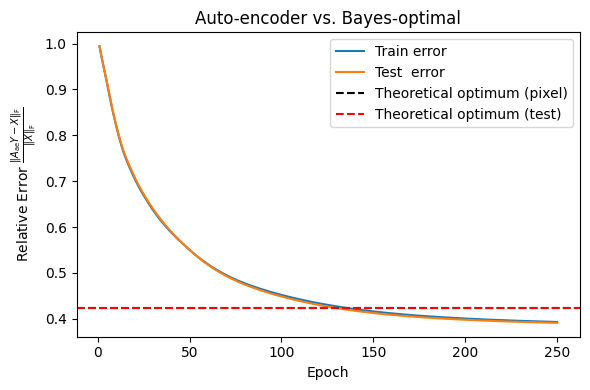

In [11]:
# --- Autoencoder setup ---
batch_size = 128 
num_epochs = 250

X_tensor = X.clone().to(torch.float32)
Y_tensor = Y.clone().to(torch.float32)

class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=False)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=False)
    def forward(self, x):
        return self.decoder(self.encoder(x))

model     = LinearAutoencoder(input_dim=dim, bottleneck_dim=r).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop using full Frobenius loss
train_errors, test_errors,  = [], []
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    # Compute learned linear operator A = W_d W_e
    A_learned = model.decoder.weight @ model.encoder.weight

    # Compute Frobenius loss: ||AY - X||_F^2
    #loss = torch.norm(A_learned @ Y - X, p="fro")**2
    loss = torch.norm(A_learned @ Y - X, p="fro") / torch.norm(X, p="fro")
    loss.backward()
    optimizer.step()

    # Evaluate and store error after each epoch
    with torch.no_grad():
        A_learned = model.decoder.weight @ model.encoder.weight
        
        err_train = torch.norm(A_learned @ Y - X, p="fro")**2
        err_test  = torch.norm(A_learned @ Y_test - X_test, p="fro")**2
        #train_errors.append(err_train.item())
        #test_errors.append(err_test.item())
        
        rel_err_train = torch.norm(A_learned @ Y - X, p="fro") / torch.norm(X, p='fro')
        rel_err_test = torch.norm(A_learned @ Y_test - X_test, p="fro") / torch.norm(X_test, p='fro')
        train_errors.append(rel_err_train.item())
        test_errors.append(rel_err_test.item())

# Plot convergence vs. theoretical optimum
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs+1), train_errors, label='Train error')
plt.plot(range(1, num_epochs+1), test_errors,  label='Test  error')
plt.axhline(rel_error_theory_pixel, ls='--', color='k', label='Theoretical optimum (pixel)')
plt.axhline(rel_error_theory_test, ls='--', color='r', label='Theoretical optimum (test)')
plt.xlabel('Epoch')
#plt.ylabel(r'Total Error $\|A_{\text{ae}} Y - X\|$')
plt.ylabel(r'Relative Error $\frac{\|A_{\text{ae}} Y - X\|_{\text{F}}}{\|X\|_{\text{F}}}$')
plt.title('Auto-encoder vs. Bayes-optimal')
plt.legend()
plt.tight_layout()
plt.show()


### Reconstruction Gallery

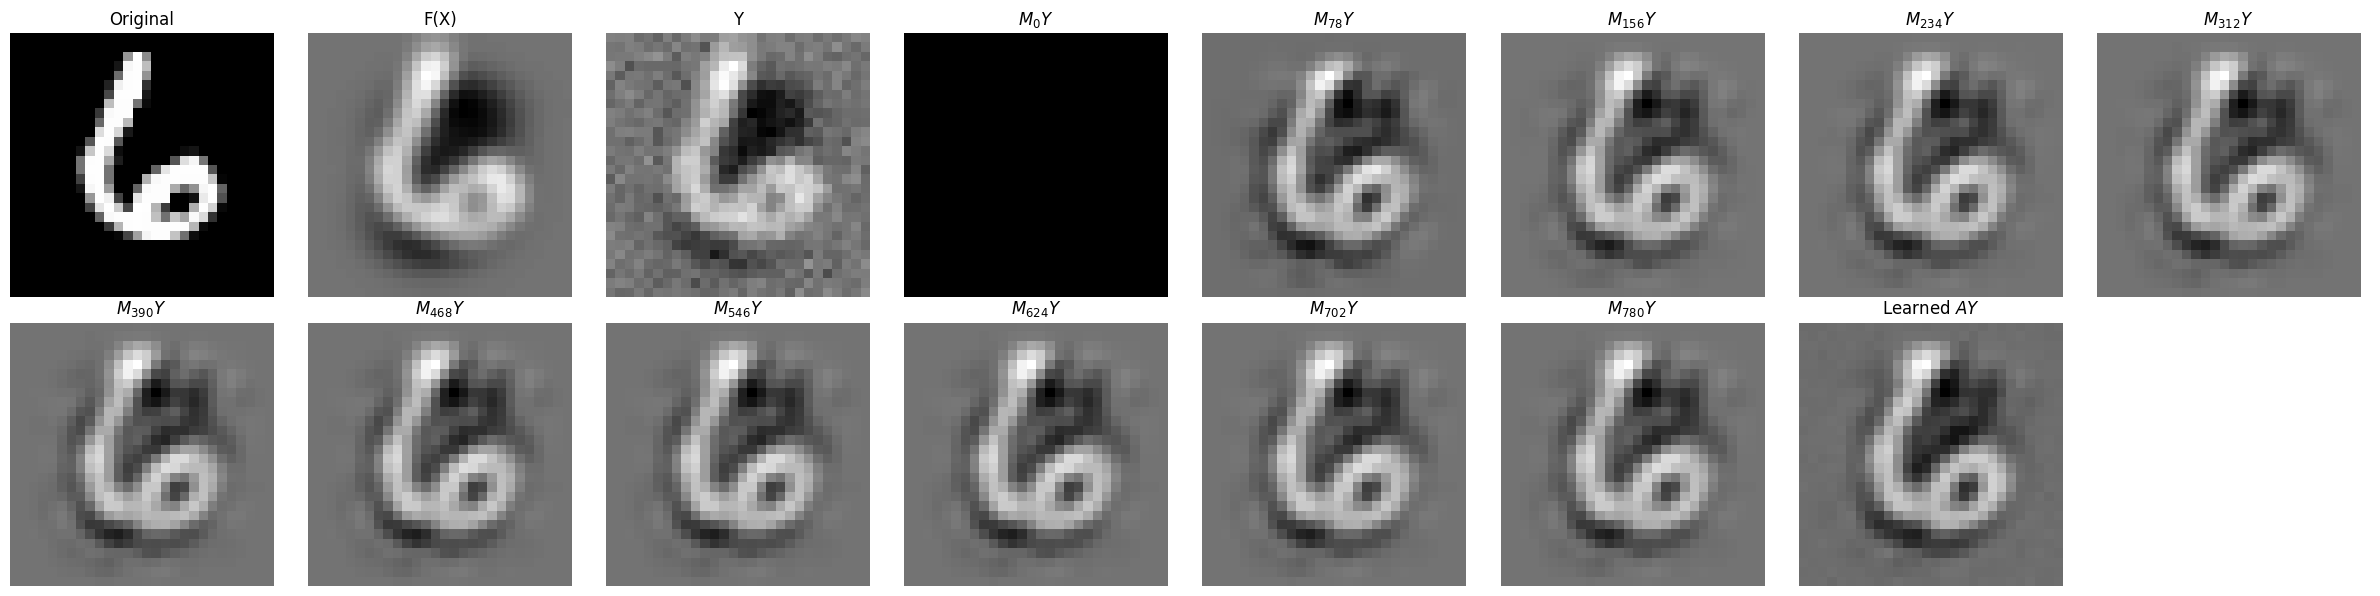

In [12]:
step      = max(1, dim // 10)
r_values  = np.arange(0, dim + 1, step)
idx       = np.random.randint(0, numSamples)

images, titles = [], []

# originals
images += [X_raw[idx], FX[:, idx], Y[:, idx]]
titles += ["Original", "F(X)", "Y"]

# reconstructions with M_r of varying rank 
errors_vs_rank = []
for r_val in r_values:
    U_tr, S_tr, Vh_tr = U[:, :r_val], torch.diag(S[:r_val]), Vh[:r_val, :]
    M_r_val = U_tr @ S_tr @ Vh_tr
    MrY_val = M_r_val @ Y
    images.append(MrY_val[:, idx])
    titles.append(f"$M_{{{r_val}}}Y$")
    err = torch.norm(M_r_val @ Y - X, p="fro")**2
    errors_vs_rank.append(err)

# learned A reconstruction 
AY = A_learned @ Y
images.append(AY[:, idx])
titles.append("Learned $A Y$")

# plot gallery 
n_plots = len(images)
n_cols  = math.ceil(n_plots / 2)
fig, axs = plt.subplots(2, n_cols, figsize=(3 * n_cols, 6))
for ax, img, title in zip(axs.flatten(), images, titles):
    ax.imshow(img.view(28, 28).cpu().numpy(), cmap="gray")
    ax.axis("off")
    ax.set_title(title)
for ax in axs.flatten()[len(images):]:
    ax.axis("off")
plt.tight_layout()
plt.show()

# error-vs-rank curve 
#plt.figure(figsize=(6, 4))
#plt.plot(r_values, errors_vs_rank, marker='o')
#plt.xlabel("Rank $r$")
#plt.ylabel("$\\|M_r Y - X\\|_F^2$")
#plt.title("Reconstruction error vs. rank of $M_r$")
#plt.grid(True)
#plt.tight_layout()
#plt.show()